In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

from flowsight.features.ae import breaches_timeseries

#Load NUH backlog data
df = breaches_timeseries()
df.head()

,date,breaches,non_breaches
0,2010-11-01,46436,1604590
1,2010-12-01,89917,1647823
2,2011-01-01,72889,1654907
3,2011-02-01,46942,1552421
4,2011-03-01,59172,1804268


In [13]:
px.line(df, x="date", y="breaches",
        title="NHS England – A&E >4-hour breaches").show()


In [2]:
px.line(df, x="date", y=["breaches", "non_breaches"], title="NHS England Total A&E > 4 hours (Nov-2010 → …)")

# df already contains columns: date, breaches, non_breaches

# fig = px.line(
#     df,
#     x="date",
#     y=["breaches", "non_breaches"],      # <- list of the two existing columns
#     labels={
#         "value": "Attendances",
#         "variable": "Metric",
#         "date": "Month"
#     },
#     title="A&E Attendances Breaches (>4 h) vs Non-breaches (≤4 h)"
# )

# fig.write_html("../outputs/ae_breach_vs_nonbreach.html")
# fig.show()


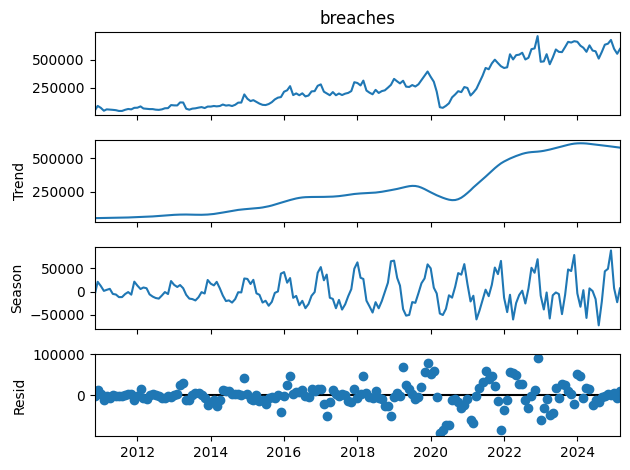

In [3]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
%matplotlib inline

series = df.set_index("date")["breaches"]
stl = STL(series, period=12)
stl_res = stl.fit()
stl_res.plot()
plt.show()


In [4]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(series)
print(f"ADF statistic: {adf[0]:.2f}  p-value: {adf[1]:.4f}")

ADF statistic: -1.09  p-value: 0.7209


In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train = series[:-6]       # hold out last 6 months
model = SARIMAX(train,
                order=(1,1,1),
                seasonal_order=(0,1,1,12),
                enforce_stationarity=False)
fit = model.fit(disp=False)
print(fit.summary())


c:\Users\ukwud\MLOps\NHS project\flowsight-nuh\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\ukwud\MLOps\NHS project\flowsight-nuh\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                     SARIMAX Results                                      
Dep. Variable:                           breaches   No. Observations:                  167
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1691.499
Date:                            Fri, 06 Jun 2025   AIC                           3390.998
Time:                                    18:55:36   BIC                           3402.764
Sample:                                11-01-2010   HQIC                          3395.779
                                     - 09-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7742      0.233      3.323      0.001       0.318       1.231
ma.L1         -0.8731      0.185   

In [18]:
pred = fit.get_forecast(steps=18)
forecast = (pred.predicted_mean
            .rename("forecast")
            .to_frame()
            .reset_index()
            .rename(columns={"index": "date"}))

# Convert date columns to pandas Timestamp so sorting works
forecast["date"] = pd.to_datetime(forecast["date"])
df["date"] = pd.to_datetime(df["date"])


In [19]:
plot_df = (
    pd.concat(
        [
            df.rename(columns={"breaches": "actual"}),
            forecast
        ],
        ignore_index=True,
    )
    .sort_values("date")
)
plot_df.tail()   # sanity check


,date,actual,non_breaches,forecast
186,2025-11-01,NaN,NaN,684152.590163
187,2025-12-01,NaN,NaN,720224.973549
188,2026-01-01,NaN,NaN,685566.141161
189,2026-02-01,NaN,NaN,665672.867374
190,2026-03-01,NaN,NaN,684067.476758


In [21]:
fig = px.line(
    plot_df,
    x="date",
    y=["actual", "forecast"],
    labels={"value": "Breaches", "variable": "Series"},
    title="A&E >4 h – actual vs 18-month SARIMAX forecast",
)
fig.write_html("../outputs/ae_breach_forecast.html")
fig.show()
